# Bayesian Multi-level Regression

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import statsmodels.api as sm

In this notebook we demo how to perform a Bayesian multi-level regression

We'll use a multi-level dataset included with R and statsmodels containing [the growth curve of pigs](https://www.rdocumentation.org/packages/doBy/versions/4.6-2/topics/data-dietox). Since we measure the weight of each pig multiple times, we'll estimate a model that allows random intercepts and slopes for time, for each pig.

### Generate data

In [2]:
# Load up data from statsmodels
data = sm.datasets.get_rdataset('dietox', 'geepack').data
data.describe()

,Pig,Litter,Start,Weight,Feed,Time
count,861.000000,861.000000,861.000000,861.000000,789.000000,861.000000
mean,6238.319396,12.135889,25.672701,60.725769,80.728645,6.480836
std,1323.845928,7.427252,3.624336,24.978881,52.877736,3.444735
min,4601.000000,1.000000,15.000000,15.000000,3.300003,1.000000
25%,4857.000000,5.000000,23.799990,38.299990,32.800003,3.000000
50%,5866.000000,11.000000,25.700000,59.199980,74.499996,6.000000
75%,8050.000000,20.000000,27.299990,81.199950,123.000000,9.000000
max,8442.000000,24.000000,35.399990,117.000000,224.500000,12.000000


### Model

In [3]:
model = bmb.Model(data)
results = model.fit('Weight ~ Time',random=['Time|Pig'], samples=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Weight_sigma, Time|Pig_offset, Time|Pig_sigma, 1|Pig_offset, 1|Pig_sigma, Time, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 54 seconds.
The number of effective samples is smaller than 25% for some parameters.


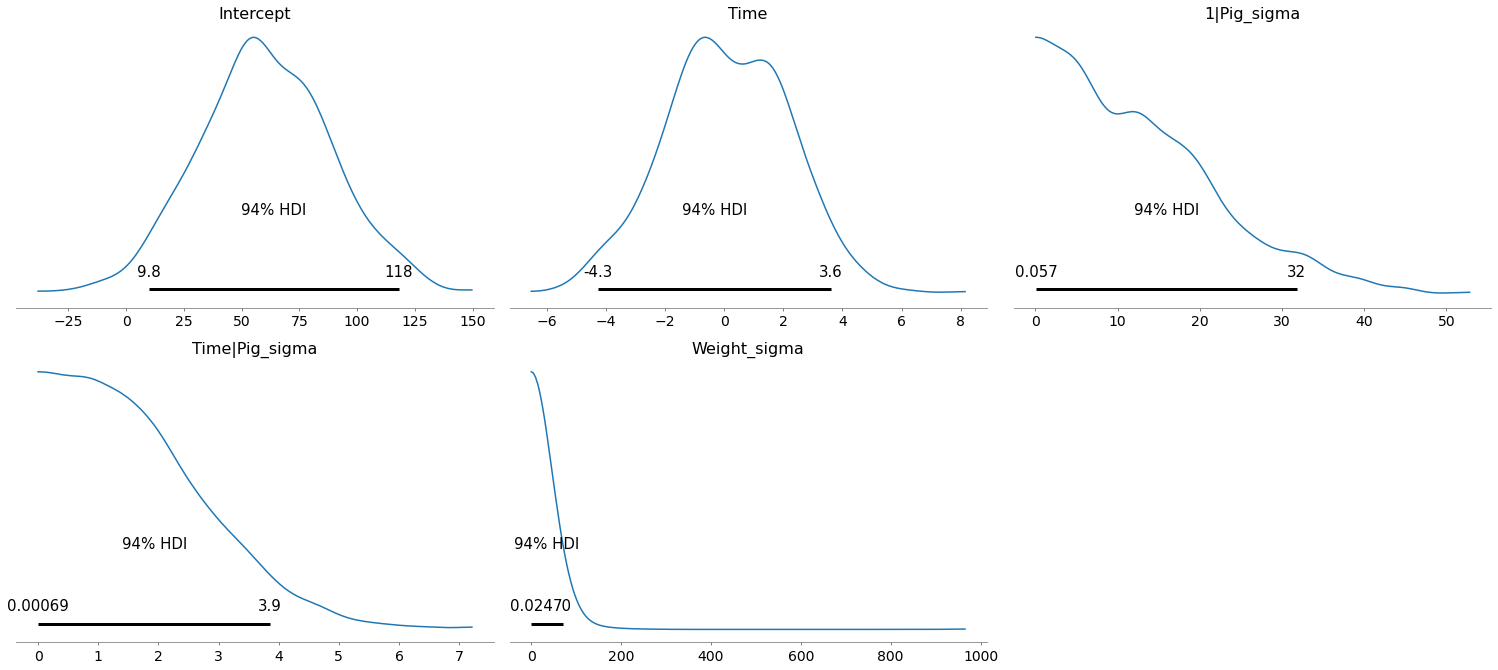

In [4]:
# Plot priors
model.plot();

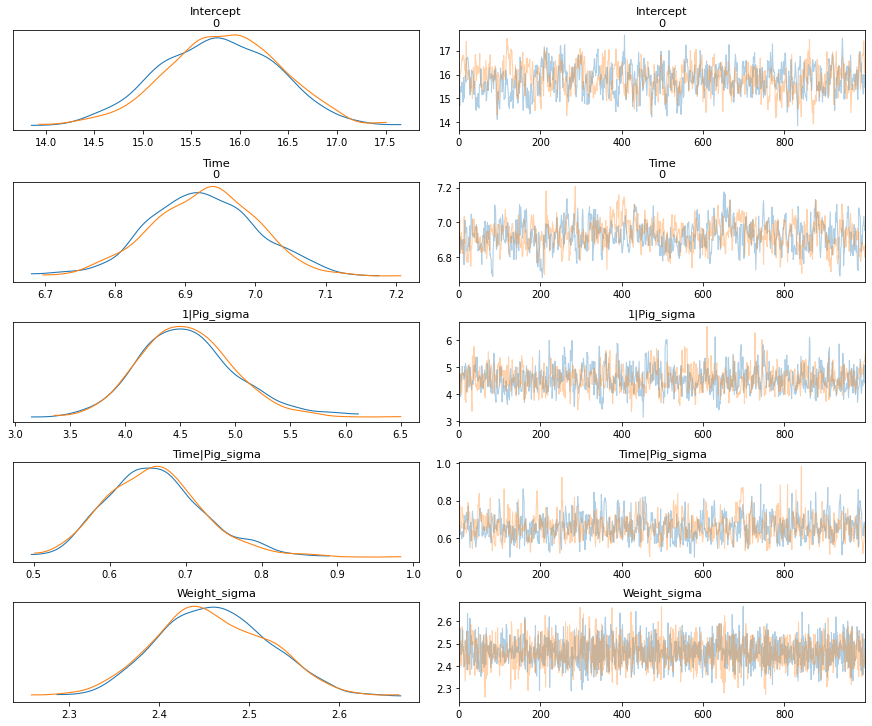

In [5]:
#Plot posteriors
az.plot_trace(
    results,
    var_names=['Intercept', 'Time', '1|Pig_sigma', 'Time|Pig_sigma', 'Weight_sigma']
);

In [6]:
az.summary(results, var_names=['Intercept', 'Time', '1|Pig_sigma', 'Time|Pig_sigma', 'Weight_sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept[0],15.803,0.588,14.681,16.867,0.032,0.022,346.0,346.0,347.0,723.0,1.01
Time[0],6.927,0.079,6.783,7.077,0.004,0.003,321.0,320.0,324.0,519.0,1.00
1|Pig_sigma,4.567,0.435,3.758,5.381,0.016,0.011,751.0,751.0,756.0,788.0,1.00
Time|Pig_sigma,0.661,0.064,0.543,0.782,0.002,0.002,660.0,654.0,676.0,754.0,1.00
Weight_sigma,2.460,0.063,2.348,2.579,0.001,0.001,2289.0,2289.0,2266.0,1549.0,1.00


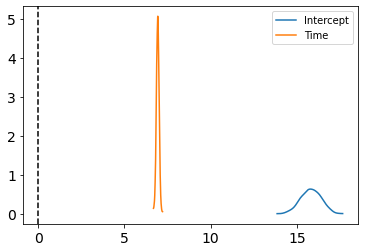

In [7]:
az.plot_kde(results.posterior['Intercept'], plot_kwargs={'color':'C0'}, label='Intercept');
az.plot_kde(results.posterior['Time'], plot_kwargs={'color':'C1'}, label='Time');
plt.axvline(0,color='k',linestyle='--')
plt.legend();

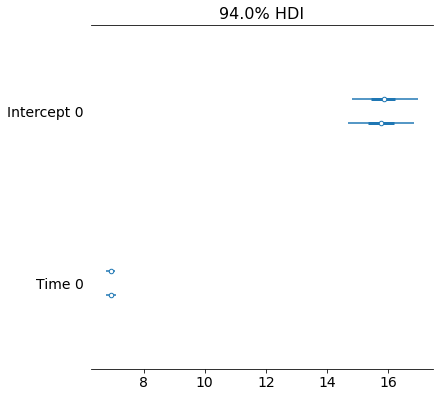

In [8]:
# Credible interval plot using pymc3
# Line is 94% credible interval calculated as higher posterior density
# Inter quartile range is thicker line
# Dot is median
az.plot_forest(
    results,
    var_names=list(map(str, model.backend.model.vars[:2]))
);

We can also plot the posterior overlayed with a region of practical equivalence (ROPE), i.e. range of values that were the coefficients to fall into, we might interpret them differently. 
We can see that all our posterior distributions fall outside of this range.

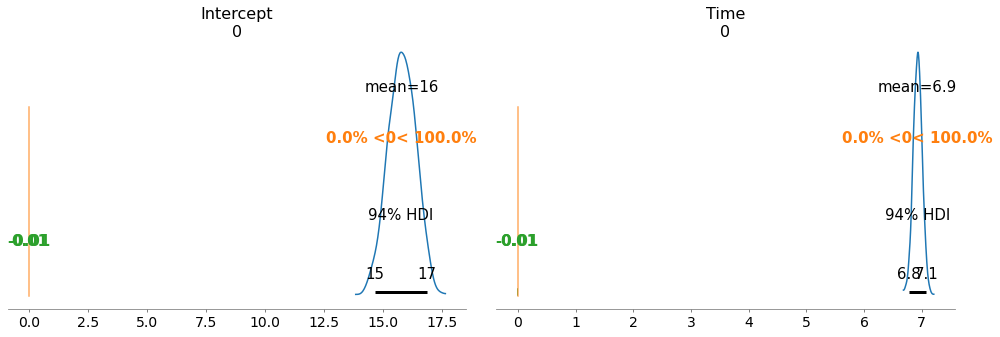

In [9]:
# Show credible interval cutoffs,
# and also overlay region of practical equivalence (arbitrary, in this case close enough to 0 do not matter)
az.plot_posterior(
    results,
    var_names=list(map(str, model.backend.model.vars[:2])),
    ref_val=0,
    rope=[-.01,.01]
);